In [1]:
import netCDF4
import matplotlib
import matplotlib.style
import matplotlib.pyplot as plt
import pandas
import numpy as np
import datetime
import pytz

%matplotlib inline
matplotlib.style.use('grayscale')


/Users/baart_f/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# local copy
# ds = netCDF4.Dataset('/Users/baart_f/models/sfo/reconstruction/OS_UH-RQH551A_20140806_R.nc')
url = 'http://uhslc.soest.hawaii.edu/thredds/dodsC/uhslc/rqh/OS_UH-RQH551A_20150401_R'
url = 'http://uhslc.soest.hawaii.edu/thredds/dodsC/uhslc/rqh/OS_UH-RQH551A_20160323_R'
ds = netCDF4.Dataset(url)
# this is the variable we're interested in
ds.variables['sea_surface_height_above_reference_level']



<class 'netCDF4._netCDF4.Variable'>
int16 sea_surface_height_above_reference_level(time, depth, latitude, longitude)
    long_name: Sea Level (HOURLY)
    units: millimeters
    _FillValue: -32768
    ancillary_variables: sensor_type_code
unlimited dimensions: time
current shape = (1034352, 1, 1, 1)
filling off

In [3]:
# get all the data
z = ds.variables['sea_surface_height_above_reference_level'][:,0,0,0]
# get the times and convert to datetime objects
t = netCDF4.num2date(ds.variables['time'][:], ds.variables['time'].units)

In [4]:
# this is in zulu time, aka as UTC
ds.variables['time'].units 

'days since 1700-01-01T00:00:00Z'

In [5]:
# make excplicit that time is in UTC
utc = pytz.timezone('UTC')
t_utc = np.array([utc.localize(t_i) for t_i in t])
# We also need the pacific timezone from back in 1962
pacific = pytz.timezone('US/Pacific')


In [6]:
# lookup the times that we need
index = np.logical_and(
    t_utc >= pacific.localize(datetime.datetime(1962, 6,10,23)), 
    t_utc < pacific.localize(datetime.datetime(1962, 6, 13,1))
)

d = pacific.localize(datetime.datetime(1962, 6, 12))
# this should be 7 hours before mid
print(d)

1962-06-12 00:00:00-07:00


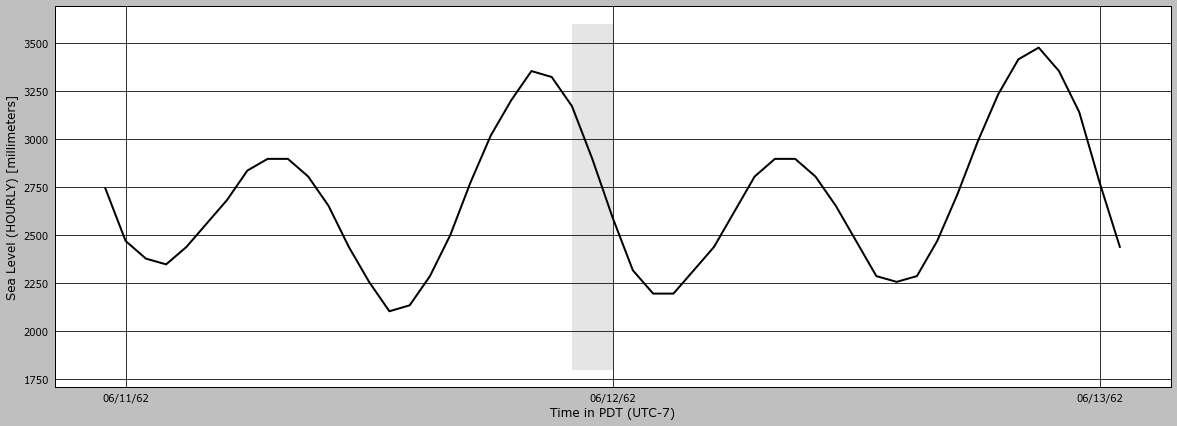

In [7]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(t[index], z[index], linewidth=2)
ax.set_xlabel('Time in PDT (UTC-7)')
name = ds.variables['sea_surface_height_above_reference_level'].long_name
unit = ds.variables['sea_surface_height_above_reference_level'].units
ax.set_ylabel('%s [%s]' % (name, unit))
ax.xaxis.set_ticks([], minor=True)

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D', tz=pacific))
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(tz=pacific))
ax.xaxis.set_minor_locator(matplotlib.dates.HourLocator(tz=pacific))
ax.fill_betweenx([1800, 3600], pacific.localize(datetime.datetime(1962,6,11,22,0)), pacific.localize(datetime.datetime(1962,6,12,0,0)), alpha=0.1)
plt.savefig('tide.pdf')

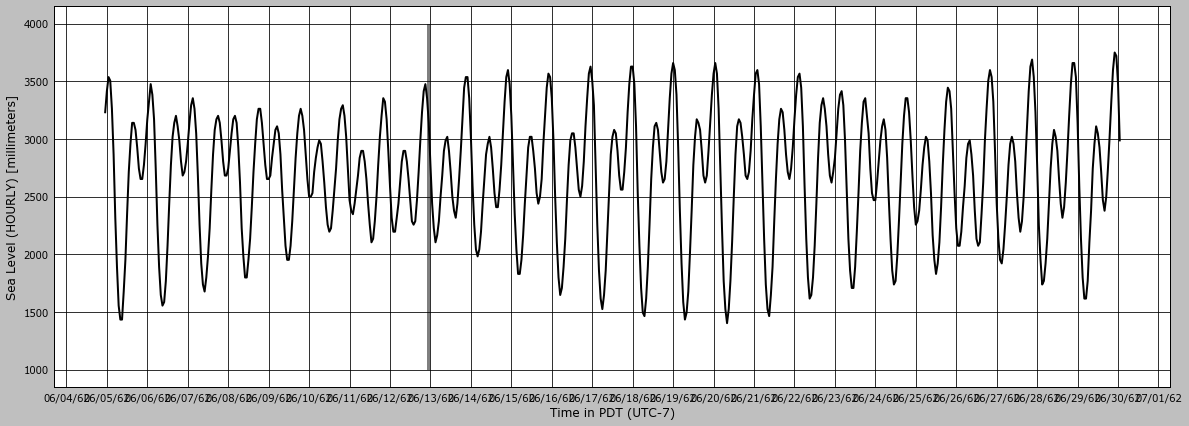

In [8]:
# spring/neap
index = np.logical_and(
    t_utc >= pacific.localize(datetime.datetime(1962, 6,4,23)), 
    t_utc < pacific.localize(datetime.datetime(1962, 6, 30,1))
)
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(t[index], z[index], linewidth=2)
ax.set_xlabel('Time in PDT (UTC-7)')
name = ds.variables['sea_surface_height_above_reference_level'].long_name
unit = ds.variables['sea_surface_height_above_reference_level'].units
ax.set_ylabel('%s [%s]' % (name, unit))
ax.xaxis.set_ticks([], minor=True)

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D', tz=pacific))
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(tz=pacific))
ax.xaxis.set_minor_locator(matplotlib.dates.HourLocator(tz=pacific))
ax.fill_betweenx([1000, 4000], 
                 pacific.localize(datetime.datetime(1962,6,12,22,0)), 
                 pacific.localize(datetime.datetime(1962,6,13,0,0)), alpha=0.5)


In [10]:
# Create an overview of timezones in 1962

# Timezone information from the Olson timezone database
reference = 'US/Pacific'
tz = pytz.timezone(reference)
# all the details are in here:
tz._transition_info

# We're showing times relative to UTC
utc = pytz.timezone('UTC')

# Lookup all the transitions
rows = []
for date, transinfo in zip(tz._utc_transition_times, tz._transition_info):
    dateutc = date.replace(tzinfo=utc)
    if dateutc.year < 1700:
        # replace year 1 by year 1700 to avoid having to deal with julian calendar
        dateutc = dateutc.replace(year=1700)
    # create a row with information
    row = {'utc': dateutc,
           'tz': dateutc.astimezone(tz),
           'diff': dateutc.astimezone(tz).replace(tzinfo=utc) - dateutc,
           'name': transinfo[2]}
    rows.append(row)

# convert it to a data frame for easier querying
df = pandas.DataFrame.from_records(rows)
# compute the difference in minutes
# note that if you use apply the timedelta is converted to a numpy timedelta, why...?
df['diff_minutes'] = df['diff'].apply(lambda x:1/60.0*x.total_seconds())
# show the first timezones used, PST was actually introduced in 1883 by the railway, seems to be fixed in later versions
# LMT is local mean time
df.head()


,diff,name,tz,utc,diff_minutes
0,-1 days +16:07:00,LMT,1699-12-31 16:07:00-07:53,1700-01-01 00:00:00+00:00,-473.0
1,-1 days +16:00:00,PST,1901-12-13 12:45:52-08:00,1901-12-13 20:45:52+00:00,-480.0
2,-1 days +17:00:00,PDT,1918-03-31 03:00:00-07:00,1918-03-31 10:00:00+00:00,-420.0
3,-1 days +16:00:00,PST,1918-10-27 01:00:00-08:00,1918-10-27 09:00:00+00:00,-480.0
4,-1 days +17:00:00,PDT,1919-03-30 03:00:00-07:00,1919-03-30 10:00:00+00:00,-420.0


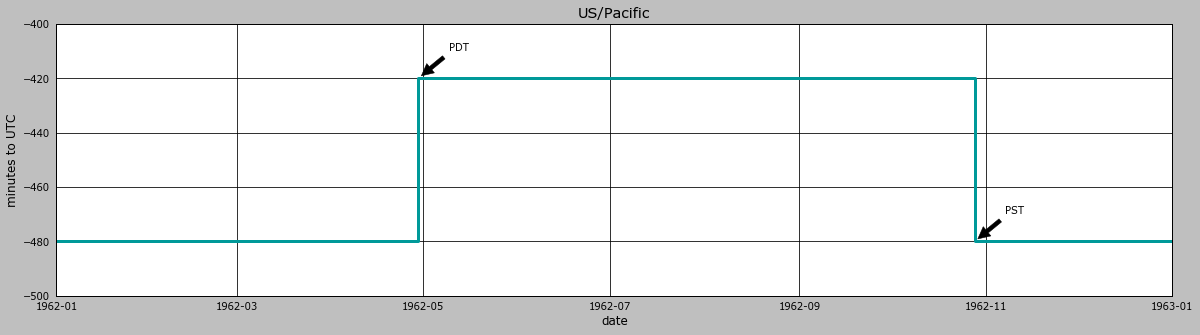

In [11]:
# plot the timezones in US/Pacific, which is equal to America/Los_angeles
fig, ax = plt.subplots(figsize=(20,5))
#  plot the timezone using a post step plot
ax.plot_date(
    df['utc'], 
    df['diff_minutes'], 
    drawstyle='steps-post', 
    linestyle='-', 
    marker='', 
    color='#009999', 
    linewidth=3
)
# # zoom-in and enhance
ax.set_xlim(
    datetime.datetime(1962,1,1), 
    datetime.datetime(1963,1,1)
)
ax.set_ylim(-500, -400)

# # labels
ax.set_xlabel('date')
ax.set_ylabel('minutes to UTC')
ax.set_title(reference)

# # annotate
arrowprops=dict(facecolor='black', shrink=0.1)
for i, row in df.iterrows():
    x = matplotlib.dates.date2num(row['tz'])
    y = row['diff_minutes']
    name = row['name']
    if row['utc'] >= utc.localize(datetime.datetime(1962,1,1)) and row['utc'] < utc.localize(datetime.datetime(1963,1,1)):
        ax.annotate(name, xy=(x,y), xytext=(x+10, y+10), arrowprops=arrowprops)

In [12]:
ds = netCDF4.Dataset('/Users/baart_f/models/sfo/sfo-3di/subgrid_map_15min.nc')
# same thing for FM model
# ds = netCDF4.Dataset('/Users/baart_f/models/sfo/baydelta/dec1999_mar2000/DFM_OUTPUT_alcatraz/alcatraz_map.nc')

In [13]:
# get the coordinates
x = ds.variables['FlowElem_xcc'][:]
y = ds.variables['FlowElem_ycc'][:]
coords = np.c_[x,y]
# I assume this is in local time PDT?, perhaps PST, see later
ds.variables['time'].units 

'seconds since 1962-06-09 00:00:00'

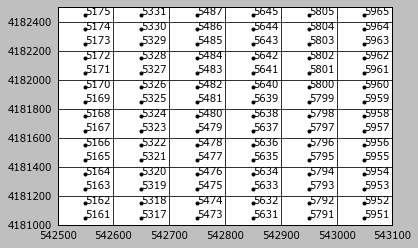

In [14]:
plt.plot(coords[:,0], coords[:,1], 'k.')
# points near fort point
xr = (542500, 543100)
yr = (4181000, 4182500)
plt.xlim(xr[0], xr[1])
plt.ylim(yr[0], yr[1])
for i, coord in enumerate(coords):
    if (xr[0] <= coord[0] < xr[1] 
        and  
        yr[0] <= coord[1] < yr[1]):
        plt.text(coord[0], coord[1], str(i))

(716401.9583333334, 716404.0416666666)

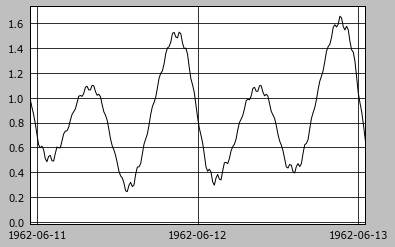

In [15]:
t = netCDF4.num2date(ds.variables['time'][:], ds.variables['time'].units)
# Plot the model water levels near fort Point
fig, ax = plt.subplots()
# it seems that the model is off by 1 hour, perhaps using PST instead of PDT?
ax.plot(t + datetime.timedelta(seconds=3600), ds.variables['s1'][:,5480])
# Format x axis
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
ax.set_xlim(
    datetime.datetime(1962, 6,10,23), 
    datetime.datetime(1962,6,13, 1)
)